#### Leo Digest    
tf.nn.conv2d (input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)    
#### 参数：
1. input : 输入的要做卷积的图片，要求为一个张量，shape为 [ batch, in_height, in_weight, in_channel ]，其中batch为图片的数量，in_height 为图片高度，in_weight 为图片宽度，in_channel 为图片的通道数，灰度图该值为1，彩色图为3。（也可以用其它值，但是具体含义不是很理解）    
1. filter： 卷积核，要求也是一个张量，shape为 [ filter_height, filter_weight, in_channel, out_channels ]，其中 filter_height 为卷积核高度，filter_weight 为卷积核宽度，in_channel 是图像通道数 ，和 input 的 in_channel 要保持一致； out_channel 是卷积核数量，out_channels 也会作为下一次卷积时的卷积核的 in_channels；    
1. strides： 卷积时在图像每一维的步长，这是一个一维的向量，[ 1, strides, strides, 1]，第一位和最后一位固定必须是1    
1. padding： string类型，值为“SAME” 和 “VALID”，表示的是卷积的形式，是否考虑边界。"SAME"是考虑边界，不足的时候用0去填充周围，"VALID"则不考虑    
1. use_cudnn_on_gpu： bool类型，是否使用cudnn加速，默认为true 
 
> max_pooling{ relu[conv2d(image, filter, strides) + biases]}

> 其中有一个重点是，比如输入图片是RGB 3通道(input in_channel)，卷积核也是3通道(filter in_channel)，那么输出是1通道，很多人不理解，为啥不是3通道啊？其实这里的1通道是把3个通道的输出合并了，也就是求和了，相当于通过求和操作把3个通道压成了1个通道，所以1个卷积核对应1个output channel    

> 每个卷积核应该学习到不同的结构特征
> 卷积核个数是在编程时自己设定的，但具体根据什么来设定我也是思考了很久。看了很多论文，都说是做多次试验得出的经验解，基本上都是32、64、128、256 这些数目的卷积核个数。
 
>池化层主要用于减小矩阵的长和宽，虽然池化层也可以用于减小矩阵的深度，但是实践中一般不会这样使用
>有研究指出池化层对模型效果的影响不大

tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    
1. ksize: 过滤器尺寸，虽然给出长度为4的一维数组，但是这个数组的第一和最后一个数必须为1；这意味着池化层过滤器是不可以跨不同输入样例或者节点矩阵深度的；实际中使用最多的是[1,2,2,1]或[1,3,3,1]    


#### 1. 假设我们输入矩阵

$
M=\left(\begin{array}{c}
1&-1&0\\
-1&2&1\\
0&2&-2
\end{array}\right)
$

In [1]:
import tensorflow as tf
import numpy as np

M = np.array([
        [[1],[-1],[0]],
        [[-1],[2],[1]],
        [[0],[2],[-2]]
    ])

print ("Matrix shape is: ",M.shape)

Matrix shape is:  (3, 3, 1)


#### 2. 定义卷积过滤器, 深度为1。
$
W=\left(\begin{array}{c}
1&-1\\
0&2
\end{array}\right)
$

In [2]:
#Two Variable Initializer

filter_weight = tf.Variable(tf.constant([[[[1]], [[-1]]],[[[0]],[[2]]]]),shape=[2,2,1,1])

"""
filter_weight = tf.get_variable('weights', [2, 2, 1, 1], initializer = tf.constant_initializer([
                                                                        [1, -1],
                                                                        [0, 2]]))

注意这里的constant_initializer的shape,实际结果如下：
[[
  [[ 1.]] 
  [[-1.]]
 ],
 [
  [[ 0.]]
  [[ 2.]]
 ]
]
"""
print("filter_weight:",filter_weight)

biases = tf.get_variable('biases', [1], initializer = tf.constant_initializer(1))

filter_weight: <tf.Variable 'Variable:0' shape=(2, 2, 1, 1) dtype=int32_ref>


#### 3. 调整输入的格式符合TensorFlow的要求。

In [3]:
M = np.asarray(M, dtype='float32')
M = M.reshape(1, 3, 3, 1)
print("M:",M)
"""
[[
   [
    [ 1.]
    [-1.]
    [ 0.]
   ],
   [[-1.]
     [ 2.]
     [ 1.]
   ],
   [
    [ 0.]
    [ 2.]
    [-2.]
   ]
 ]]
"""

M: [[[[ 1.]
   [-1.]
   [ 0.]]

  [[-1.]
   [ 2.]
   [ 1.]]

  [[ 0.]
   [ 2.]
   [-2.]]]]


#### 4.  计算矩阵通过卷积层过滤器和池化层过滤器计算后的结果。

In [4]:
x = tf.placeholder('float32', [1, None, None, 1])
conv = tf.nn.conv2d(x, filter_weight, strides = [1, 2, 2, 1], padding = 'SAME')
bias = tf.nn.bias_add(conv, biases)
pool = tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print("sess.run filter_weight:",sess.run(filter_weight))
    
    convoluted_M = sess.run(bias,feed_dict={x:M})
    pooled_M = sess.run(pool,feed_dict={x:M})
    
    print ("convoluted_M: \n", convoluted_M)
    print ("pooled_M: \n", pooled_M)

sess.run filter_weight: [[[[ 1.]]

  [[-1.]]]


 [[[ 0.]]

  [[ 2.]]]]
convoluted_M: 
 [[[[ 7.]
   [ 1.]]

  [[-1.]
   [-1.]]]]
pooled_M: 
 [[[[ 0.25]
   [ 0.5 ]]

  [[ 1.  ]
   [-2.  ]]]]


# 介绍
tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)    
## input： 
指需要做卷积的输入图像，它要求是一个Tensor，具有[batch, in_height, in_width, in_channels]这样的shape，    
具体含义是[训练时一个batch的图片数量, 图片高度, 图片宽度, 图像通道数]，注意这是一个4维的Tensor，
要求类型为float32和float64其中之一    
## filter：
相当于CNN中的卷积核，它要求是一个Tensor，具有[filter_height, filter_width, in_channels, out_channels]这样的shape，    
具体含义是[卷积核的高度，卷积核的宽度，图像通道数，卷积核个数]，要求类型与参数input相同，有一个地方需要注意，第三维in_channels，    
就是参数input的第四维    
## strides：
卷积时在图像每一维的步长，这是一个一维的向量，长度4    
## padding：    
string类型的量，只能是”SAME”,”VALID”其中之一，这个值决定了不同的卷积方式（后面会介绍）    
## use_cudnn_on_gpu：
bool类型，是否使用cudnn加速，默认为true    

## 结果
返回一个Tensor，这个输出，就是我们常说的feature map    

## 实验

1. 考虑一种最简单的情况，现在有一张3×3单通道的图像（对应的shape：[1，3，3，1]），用一个1×1的卷积核（对应的shape：[1，1，1，1]）去做卷积，最后会得到一张3×3的feature map    

2. 增加图片的通道数，使用一张3×3五通道的图像（对应的shape：[1，3，3，5]），用一个1×1的卷积核（对应的shape：[1，1，1，1]）去做卷积，仍然是一张3×3的feature map，这就相当于每一个像素点，卷积核都与该像素点的每一个通道做点积    
```
input = tf.Variable(tf.random_normal([1,3,3,5]))
filter = tf.Variable(tf.random_normal([1,1,5,1]))
op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')
```
3. 把卷积核扩大，现在用3×3的卷积核做卷积，最后的输出是一个值，相当于情况2的feature map所有像素点的值求和    
```
input = tf.Variable(tf.random_normal([1,3,3,5]))    
filter = tf.Variable(tf.random_normal([3,3,5,1]))    
op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='VALID')        
```
4. 使用更大的图片将情况2的图片扩大到5×5，仍然是3×3的卷积核，令步长为1，输出3×3的feature map    
5. 上面我们一直令参数padding的值为‘VALID’，当其为‘SAME’时，表示卷积核可以停留在图像边缘，如下，输出5×5的feature map        
```
input = tf.Variable(tf.random_normal([1,5,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,1]))
op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME')
```
6. 如果卷积核有多个    
```
input = tf.Variable(tf.random_normal([1,5,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,7]))
op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME')
此时输出7张5×5的feature map
```
7. 步长不为1的情况，文档里说了对于图片，因为只有两维，通常strides取[1，stride，stride，1]
```
input = tf.Variable(tf.random_normal([1,5,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,7]))
op = tf.nn.conv2d(input, filter, strides=[1, 2, 2, 1], padding='SAME')
此时，输出7张3×3的feature map
```
8. 如果batch值不为1，同时输入10张图
```
input = tf.Variable(tf.random_normal([10,5,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,7]))
op = tf.nn.conv2d(input, filter, strides=[1, 2, 2, 1], padding='SAME')
每张图，都有7张3×3的feature map，输出的shape就是[10，3，3，7]
```
9. 策略是valid时的shape计算    
    输入的数据是[100,80,100,4]的数据，经过的卷积核是[8,8,4,32],步长为[1,4,4,1]策略是valid，那么首先输入的batch=100是不会变的，深度4要变成输出的32，输入图片长度80要在长为8的卷积核下以步长4划过一次，那么抹布的右边缘所处的像素点横坐标应当依次是8,12,16,20……80一共19次计算，所以输出结果的长应当是19，同理，输出结果的宽应当是24，因此输出结果的形状应当是[100,19,24,32]  

height： [(80-8)/4 ]+1 = 19    
width：  [(100-8)/4]+1 = 24      
batch和out_channels：不变    
feature map：[100 , 19, 24, 32]   

   将上一步的结果输入卷积核[4,4,32,64],步长调整为[1,2,2,1]，模式依旧是valid，那么输出结果是[100,8,11,64]
#### 总结：     
height： [(height - filter_height)/strides ]+1        
width：  [(widtg  - filter_width) /strides ]+1    

```
在caffe中是这样的：
out_height =floor(in_height+2*pad-filter_height)/stride+1; floor向下取整
out_width=floor(in_width+2*pad-filter_width)/stride+1
在TensorFlow中是这样的：
"SAME" 类型的padding:
out_height = ceil(in_height / strides[1]); ceil向上取整
out_width = ceil(in_width / strides[2])
"VALID"类型的padding:
out_height = ceil((in_height - filter_height + 1) / striders[1])
out_width = ceil((in_width - filter_width + 1) / striders[2]
```

Extracting ./leo-mnist/train-images-idx3-ubyte.gz
Extracting ./leo-mnist/train-labels-idx1-ubyte.gz
Extracting ./leo-mnist/t10k-images-idx3-ubyte.gz
Extracting ./leo-mnist/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.1
i= 2
rhconv2d (1, 28, 28, 32)
rhconv2d2 (1, 14, 14, 64)


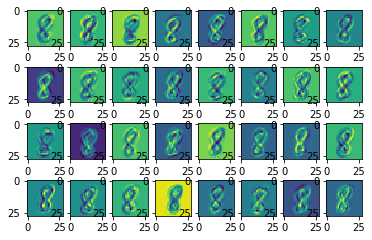

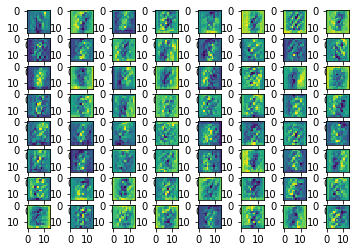

step 100, training accuracy 0.82
step 200, training accuracy 0.9
step 300, training accuracy 0.86
step 400, training accuracy 0.92
step 500, training accuracy 0.94
step 600, training accuracy 0.94
step 700, training accuracy 0.96
step 800, training accuracy 0.92
step 900, training accuracy 0.98
step 1000, training accuracy 0.9
step 1100, training accuracy 0.98
step 1200, training accuracy 0.94
step 1300, training accuracy 0.98
step 1400, training accuracy 0.98
test accuracy 0.9751


In [19]:
import sys
import importlib
import matplotlib.pyplot as plt
import numpy as np
#importlib.reload(sys)

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets('./leo-mnist', one_hot=True)

# 初始化生成随机的权重(变量)，避免神经元输出恒为0
def weight_variable(shape):
    # 以正态分布生成随机值
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# 初始化生成随机的偏置项(常量)，避免神经元输出恒为0
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 卷积采用1步长，0边距，保证输入输出大小相同
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# 池化采用2×2模板
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME')

# 28*28=784
x = tf.placeholder(tf.float32, [None, 784])
# 输出类别共10个：0-9
y_ = tf.placeholder("float", [None,10])

# 第一层卷积权重，视野是5*5，输入通道1个，输出通道32个
W_conv1 = weight_variable([5, 5, 1, 32])
# 第一层卷积偏置项有32个
b_conv1 = bias_variable([32])

# 把x变成4d向量，第二维和第三维是图像尺寸，第四维是颜色通道数1
x_image = tf.reshape(x, [-1,28,28,1])
h_conv2d1 = conv2d(x_image, W_conv1)
h_conv1 = tf.nn.relu(h_conv2d1 + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积权重，视野是5*5，输入通道32个，输出通道64个
W_conv2 = weight_variable([5, 5, 32, 64])
# 第二层卷积偏置项有64个
b_conv2 = bias_variable([64])
h_conv2d2 = conv2d(h_pool1, W_conv2)
h_conv2 = tf.nn.relu(h_conv2d2 + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 第二层池化后尺寸编程7*7，第三层是全连接，输入是64个通道，输出是1024个神经元
W_fc1 = weight_variable([7 * 7 * 64, 1024])
# 第三层全连接偏置项有1024个
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# 按float做dropout，以减少过拟合
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 最后的softmax层生成10种分类
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))

# Adam优化器来做梯度最速下降
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(1500):
    batch = mnist.train.next_batch(50)
    if i == 2:
        print("i=",i)
        rhconv2d=sess.run(h_conv2d1,feed_dict={x: [batch[0][0]], y_: [batch[1][0]], keep_prob: 0.5})
        rhconv2d2=sess.run(h_conv2d2,feed_dict={x: [batch[0][0]], y_: [batch[1][0]], keep_prob: 0.5})
        print("rhconv2d",rhconv2d.shape)
        print("rhconv2d2",rhconv2d2.shape)
        plt.figure(num='rhconv2d')
        for lay in range(32):        
            data=[]
            for j in  range(28):
                for i in range(28):
                    data.append(rhconv2d[0][j][i][lay])
            plt.subplot(4,8,lay+1)
            plt.imshow(np.asarray(data).reshape(28,28))
        plt.show()
        plt.figure(num='conv2d2')
        
        for lay in range(64):
            data=[]
            for j in  range(14):
                for i in range(14):
                    data.append(rhconv2d2[0][j][i][lay])
            plt.subplot(8,8,lay+1)
            plt.imshow(np.asarray(data).reshape(14,14))
        plt.show()
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

In [3]:
# Import MNIST data
import tensorflow as tf ##
from tensorflow.examples.tutorials.mnist import input_data ##
mnist = input_data.read_data_sets("/tmp/data3/", one_hot=True)##

# Training Parameters
learning_rate = 0.01
num_steps = 2000
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)##
num_classes = 10 # MNIST total classes (0-9 digits)##
dropout = 0.5 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input]) ##
Y = tf.placeholder(tf.float32, [None, num_classes]) ##
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)


# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    #x1 = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    #x2 = tf.nn.bias_add(x1, b)
    #return tf.nn.relu(x2)
    return tf.nn.relu(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') + b)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])   ##
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2) ##

    # Convolution Layer 
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])  ## 
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)  ##

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, 7*7*64])  ##weights['wd1'].get_shape().as_list()[0]]) ##
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Store layers weight & bias
#weights = {
#    # 5x5 conv, 1 input, 32 outputs
#    'wc1':tf.Variable(tf.random_normal([5, 5, 1, 32])), ## 
#    # 5x5 conv, 32 inputs, 64 outputs
#    'wc2':tf.Variable(tf.random_normal([5, 5, 32, 64])),
#    # fully connected, 7*7*64 inputs, 1024 outputs
#    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
#    # 1024 inputs, 10 outputs (class prediction)
#    'out': tf.Variable(tf.random_normal([1024, num_classes]))
#}
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1':tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1)), ## 
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2':tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1)), ##
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1)), ## 
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.1)) ##
}
biases = {
    'bc1': tf.Variable(tf.constant(0.1, shape=[32])), ##
    'bc2': tf.Variable(tf.constant(0.1, shape=[64])), ##
    'bd1': tf.Variable(tf.constant(0.1, shape=[1024])), ##
    'out': tf.Variable(tf.constant(0.1, shape=[num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)


# Define loss and optimizer
#######  loss 函数很重要！这里是reduce_sum,别和下面的reduce_mean混为一谈
#######  隔天我改成reduce_mean,又好了
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
         logits=logits, labels=Y))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss_op)

######
#softmax = tf.nn.softmax(logits)
#cross_entropy = -tf.reduce_sum(Y * tf.log(softmax))
#train_op = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
######

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1500):
        batch = mnist.train.next_batch(50)
        if i==0 :
            print("batch shape:",type(batch[0]),batch[0].shape,batch[1].shape)
        sess.run(train_op, feed_dict={X:batch[0],Y:batch[1], keep_prob:0.5})
        if i % 100 == 0:
            print(sess.run(accuracy, feed_dict={X:batch[0],Y:batch[1], keep_prob:1.0}))
        
    print("accuracy:",sess.run(accuracy, feed_dict={X:mnist.test.images,Y:mnist.test.labels, keep_prob:1.0}))
          

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data3/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data3/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data3/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data3/t10k-labels-idx1-ubyte.gz
batch shape: <class 'numpy.ndarray'> (50, 784) (50, 10)
0.14
0.82
0.98
0.96
0.92
0.96
0.98
0.94
0.94
0.9
0.94
1.0
0.98
0.98
0.98
accuracy: 0.9742
